# **AMLAS (AERO 689) Assignment #1**

Topology Optimization for Structures

Devin Smith
AERO 489/689

**Objective**

We want to perform topology optimization for a load bearing can-
tilever. The initial workspace will be a rectangular bar as shown in the figure
below. We are interested in determining the optimal topology of the structure

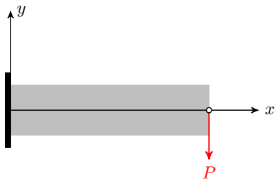

Figure 1: Cantilever beam with load *P* applied at the end. The length of the cantilever is *L* and the thickness is *w*.

that can carry a load of *P*.

**Representation**

1. Discretize the structure with a fine rectangular grid of points. These will
define the nodes. These nodes will be equally spaced with constant *dx* and *dy*. Values of *dx* and *dy* will define how fine the mesh is.

2. Only those nodes that are attached to the left fixture will have reaction
forces acting on them. All other nodes will be free and not have any
reaction force acting on them.

3. The members will be defined using nearest neighbor algorithm. A given
node will be connected to nodes that are within Screenshot 2024-01-31 092737.png
distance.
The connectivity matrix will be generated using this information. Make
sure you do not have duplicate members.
4.
5. Solve the optimization problem for the minimum mass. Prove that the
structure’s mass is equivalent to weighted 1-norm of the force densities. For this assignment, only consider equilibrium condition. Therefore, you
problem will be very similar to the problem solved in class, except the
const function.
6. Choose a material of choice, and compute the minimum radius of each
member from the yield stress (tensile members) and buckling stress (com-
pressive members). Compute the mass of the total structure from this
information.

Your answer should look similar to the following image, for the dimensions
chosen. Good luck!
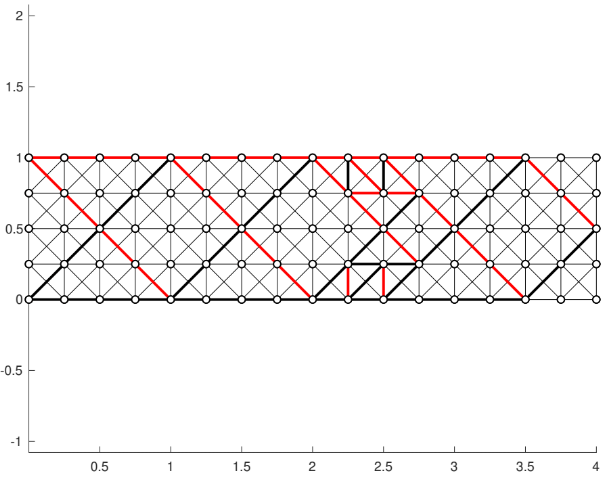


# Solution

In [1]:
# ---- IMPORTS  ----


import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt


# ---- FUNCTIONS ----


def nodes(l, h, dx, dy):
  '''
  node matrix is numbered starting in bottom left corner
  numbering goes from bottom to top, left to right
  EX: 3-6-9
      |X|X|
      2-5-8
      |X|X|
      1-2-3
  '''
  # CALCULATE NUMBER OF NODES
  nx, ny = int(l/dx) + 1, int(h/dy) + 1       # number of nodes in x and y dir.
  n = nx*ny                                   # total number of nodes

  # CREATE NODAL MATRIX
  N_matrix = np.zeros((2, n))
  node = 0                                    # track node number
  for i in range(nx):                         # loop through x nodes
    for j in range(ny):                       # loop through y nodes
      x, y = i*dx, j*dy                       # calculate x,y at node
      N_matrix[0, node] = x                   # set x value in matrix
      N_matrix[1, node] = y                   # set y value in matrix
      node += 1                               # increment node
  return N_matrix


def connectivity(l, h, dx, dy):
  '''
  members start numbering in bottom left corner
  numbering goes from bottom to top, left to rights
  creates members "box" by "box", where the box is made from 4 adjacent nodes
  creates these boxes using the bottom left node as the reference node
  EX: 2 4
      |X      <-- 2 bars left out in order to avoid repeats
      1-3         however, on edge cases, will create top bar and right bar
  '''
  # CALCULATE NUMBER OF NODES
  nx, ny = int(l/dx) + 1, int(h/dy) + 1 # number of nodes in x and y
  n = nx*ny                     # total number of nodes

  # CREATE CONNECTIVITY MATRIX AND MEMBER LENGTH MATRIX
  C_array = []                  # list of member connectivities
  L_array = []                  # list of member lengths
  node = 0                      # track node number
  for i in range(nx - 1):       # loops through every column (except right-most)
    for j in range(ny - 1):     # loops through every row (except top-most)

      node1 = node                              # 4 nodes of current node's box
      node2 = node + 1
      node3 = node + ny
      node4 = node + ny + 1

      C_append(C_array, n, node1, node2)        # left bar    |
      C_append(C_array, n, node1, node3)        # bottom bar  -
      C_append(C_array, n, node1, node4)        # diag1 bar   /
      C_append(C_array, n, node2, node3)        # diag2 bar   \

      L_array.append(dy)                        # left bar    |
      L_array.append(dx)                        # bottom bar  -
      L_array.append(np.sqrt(dx**2 + dy**2))    # diag1 bar   /
      L_array.append(np.sqrt(dx**2 + dy**2))    # diag2 bar   \

      if i == nx - 2:
        C_append(C_array, n, node3, node4)      # top bar     -
        L_array.append(dy)
      if j == ny - 2:
        C_append(C_array, n, node2, node4)      # right bar   |
        L_array.append(dx)
        node += 1                               # skips nodes at very top

      node += 1                                 # increment node (box)
  C_array = np.array(C_array)                   # turn list into array
  L_array = np.array(L_array)

  # return connectivity matrix and member length vector
  return C_array, L_array


def C_append(C_array, num_nodes, node1, node2):
  '''
  creates member connectivity using given nodes
  '''
  # CREATE MEMBER AND CONNECTIVITY
  bar = np.zeros(num_nodes)
  bar[node1], bar[node2] = 1,-1
  C_array.append(bar)


def force(l, h, dx, dy, P):
  '''
  creates external force matrix using user inputs to problem
  '''
  # CALCULATE NUMBER OF NODES
  nx = int(l/dx)
  ny = int(h/dy)
  n = (nx+1)*(ny+1)

  # CREATE FORCE MATRIX
  F_matrix = np.zeros((2, n))
  F_node = int(n - ny/2 - 1)
  F_matrix[1, F_node] = P
  return F_matrix


def plot(N, C, F_b, F_c):
  '''
  Plots the optimized structure using the user inputs
  '''
  # CREATE PLOT OF ALL MEMBERS
  m,_ = C.shape                             # m = # of members
  for i in range(m):                        # loop through # of members
      j = np.nonzero(C[i])                  # gives all js of nonzero #s in row

      # PLOTTING BARS/CABLES
      if F_b[i] > 1.0E-3:                   # check if non-zero
        plt.plot(N[0, j][0], N[1, j][0],    # plot bars
                 'k', linewidth=1)
      elif F_c[i] > 1.0E-3:                 # check if non-zero
        plt.plot(N[0, j][0], N[1, j][0],    # plot cables
                   'r', linewidth=1)

      # PLOTTING NODES
      if F_b[i] > 1.0E-3 or F_c[i] > 1.0E-3:  # check if non-zero
        plt.plot(N[0, j][0], N[1, j][0],      # plot bars
                 'ko', markersize=2)

  # GRAPH SETTINGS
  plt.title("Optimized Cantilever Beam")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.axis('equal')
  plt.show()


def optimize(N, C, F, L, material):
  '''
  optimizes equilibrium solution using the desired cost function
  '''
  m,n = C.shape                               # num of members and nodes

  # MATERIAL PROPERTIES
  E = material.youngs_modulus
  rho = material.density
  sig_y = material.yield_stress

  # REACTION FORCE VARIABLE
  R = cp.Variable((2, n))
  ii = []                                     # list of zero-reaction
  for i in range(len(N[0])):                  # loops through nodes
    if N[0, i] != 0.:                         # checks for nodes not at wall
      ii.append(i)                            # adds zero-reaction node

  # BAR AND CABLE FORCE DENSITY VARIABLE
  sig_b = cp.Variable(m, nonneg=True)
  sig_c = cp.Variable(m, nonneg=True)

  # AREA VARIABLES
  A_b = cp.Variable(m, nonneg=True)
  A_c = cp.Variable(m, nonneg=True)

  # CONSTRAINTS
  Constraints = []

  # equilibrium constraints
  Constraints.append(N@C.T@cp.diag(sig_c)@C -
                     N@C.T@cp.diag(sig_b)@C -
                     F - R == 0)
  Constraints.append(R[:,ii] == 0)

  # yield stress constraints
  Constraints.append(cp.multiply(sig_c,L) <= cp.multiply(sig_y,A_c))
  Constraints.append(cp.multiply(sig_b,L) <= cp.multiply(sig_y,A_b))

  # MINIMIZE AREA SOLUTION (FIRST ITERATION)
  # lambda = E*A/L --> A = lambda*L/E
  # E is the same for every bar therefore it is not needed in cost function
  # (also if I divide by E, then it messes everything up. IDK why)

  cost = (cp.norm1(cp.multiply(sig_c,L)) +
          cp.norm1(cp.multiply(sig_b,L)))
  prob = cp.Problem(cp.Minimize(cost), Constraints)
  prob.solve()

  # MINIMIZE AREA SOLUTION (SECOND ITERATION)
  # secret sauce = weight the force densities by inverse of previous iteration

  # add constraint for buckling
  tau = cp.multiply(sig_b.value, L)
  sig_buck = cp.multiply(cp.power(L,-1), cp.sqrt(cp.multiply(np.pi*E, tau)))
  Constraints.append(cp.multiply(sig_b, L) <= cp.multiply(sig_buck, A_b) - tau)

  b_w = []                                        # weight for bar
  c_w = []                                        # weight for cable
  for i in range(len(sig_c.value)):
    if sig_c.value[i] == 0.0:
      c_w.append(0.0)
    else:
      c_w.append(sig_c.value[i]**-1)
    if sig_b.value[i] == 0.0:
      b_w.append(0.0)
    else:
      b_w.append(sig_b.value[i]**-1)

  # new cost function with weights
  cost = (cp.norm1(cp.multiply(cp.multiply(sig_c,L), c_w)) +
          cp.norm1(cp.multiply(cp.multiply(sig_b,L), b_w)))
  prob = cp.Problem(cp.Minimize(cost), Constraints)
  prob.solve()

  safety = 3.0
  A_b_val = sig_b.value*L/sig_y*safety
  A_c_val = sig_c.value*L/sig_y*safety

  # A_b_val = sig_b.value*L/sig_buck

  return [R.value, sig_b.value, sig_c.value, A_b_val, A_c_val]


def mass(F_b, A_b, F_c, A_c, L, material):
  V = 0
  for i in range(len(F_b)):
    if F_b[i] > 1.0E-3:
       V += A_b[i]*L[i]
    if F_c[i] > 1.0E-3:
       V += A_c[i]*L[i]
  M = V*material.density
  return M

# ---- CLASSES ----


class aluminum6061:
  yield_stress = 240E6        # N/m^2
  density = 2700              # Kg/m^3
  youngs_modulus = 69E9       # N/m^2


class steel:
  yield_stress = 250E6        # N/m^2
  density = 8000              # Kg/m^3
  youngs_modulus = 200E9      # N/m^2



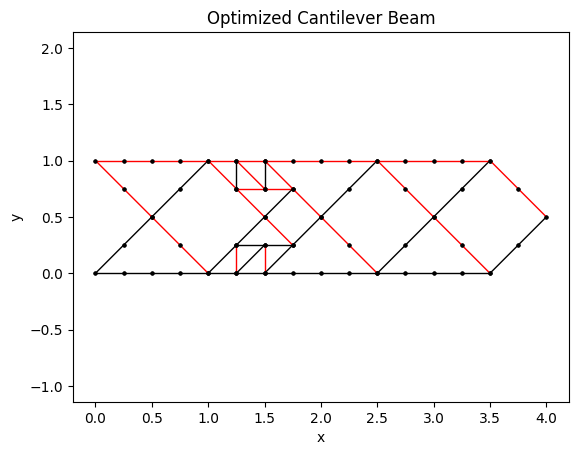


applied force: -750 N

material: steel
yield stress: 250000000.0 Pa
young's modulus: 200000000000.0 Pa
density: 8000 kg/m^3

opmtimized mass (with factor of safety 3): 1.7279999987116967 kg


In [5]:
# material options
materials = [aluminum6061, steel]

# ---------- USER INPUT ----------- #

l = 4
h = 1
dx = 0.25
dy = 0.25

P = -750

mat = materials[1]

# --------------------------------- #

# SOLVING THE PROBLEM
# 1) generate nodal matrix, connectivity matrix, member lengths, & force matrix
N = nodes(l, h, dx, dy)
C, L = connectivity(l, h, dx, dy)
F = force(l, h, dx, dy, P)

# 2) solve for forces in opimization function
solution = optimize(N, C, F, L, mat)

Reactions = solution[0]
F_bar, F_cable = solution[1], solution[2]
A_bar, A_cable = solution[3], solution[4]

# 3) plot the solution
plot(N,C, F_bar, F_cable)

# 4) total mass
total_mass = mass(F_bar, A_bar, F_cable, A_cable, L, mat)

# 5) report the output

print()
print("applied force:", P, "N")
print()
print("material:", mat.__name__)
print("yield stress:", mat.yield_stress, "Pa")
print("young's modulus:", mat.youngs_modulus, "Pa")
print("density:", mat.density, "kg/m^3")
print()
print("opmtimized mass (with factor of safety 3):", total_mass, "kg")

# Analysis

**Problem Setup: Nodal Matrix, Connectivity Matrix, Applied Force and Reaction Forces.**

Setting up these matrices was done by using the pattern for a rectangular array of nodes. While my method for applying this pattern worked, I am sure there are more computationally efficient methods of calculating these matrices, particularly the connectivity matrix. I am not the most skilled when it comes to indexing in python.

**Optimization Setup: Constraints, Cost Functions**

The constraints imposed were the equilibrium constraints and the stress constraints. These constraints used the material properties and ensured that the materials would not fail.

The cost function is the norm1 of the sum of forces (force density * member length). This was derived using the relation between area and force density. The variable missing from the cost function formula is the youngs modulus, but since the youngs modulus is the same constant for every bar, it was left out of the cost function.

**Results: Optimized Structure, Total Mass**

When optimizing the solution, there was a second iteration, where the force densities from the first iteration were used to weight a second solution. These force densities were inverted when used as weights, so that the force densities that were close to zero would be weighted by large amounts. This resulted in a solution very similar to the given image for this assignment. There was also an addition of the buckling constraint using the previous iteration as a guess, but I am unsure if I implemented that correctly.

When looking at the Area variable solved in the CVXPY optimization itself, they were a lot bigger than expected, so instead, I used the optimized force densities solved from CVXPY, length, and yield stresses to calculate the areas instead (with a factor of safety).

**Reflection**

Overall, this assignment was an interesting excercise to familiarize myself with CVXPY, and how the cost functions really affect the results. I found that my constraints did not affect the soltion that much, but I would need to test more edge cases to see the effects of those constraints. I am not sure how CVXPY solves the optimization, as it basically is just a magic box that does it for me. Therefore, I am not sure why the solve returns "none" if I try to iterate the solution more than twice. This requires further investigation. Upon looking at the MATLAB solution, I see that there is much less code to achieve the same result. I belive part of this is due to the capabilities of MATLAB, but also my inexperience in creating efficient code.